# Bayes最適化デモ<BR>
<div style="text-align: right;">
Feb. 2023 初版作成：中山将伸<BR>
Nov. 2025 改訂(グラフ追加)：中山将伸<BR>

</div>


### 論文データを用いたベイズ最適化例
タスク１　不完全に埋められたデータ表(LCYZP_36open.csv)から次の１点をEI 値から選択する<BR>
タスク２　完全に埋まったデータ表を使って「ランダムサンプリング」と「ベイズ最適化」のパフォーマンスを比較チェックする<BR>

データ引用元：　K. Nakano, Y. Noda, N. Tanibata, H. Takeda, M. Nakayama, R. Kobayashi, I. Takeuchi, "Exhaustive and Informatics-Aided Search for Fast Li-Ion Conductor with NASICON-Type Structure Using Material Simulation and Bayesian Optimization", APL Materials,  8, 041112 (2020)　https://doi.org/10.1063/5.0007414
    

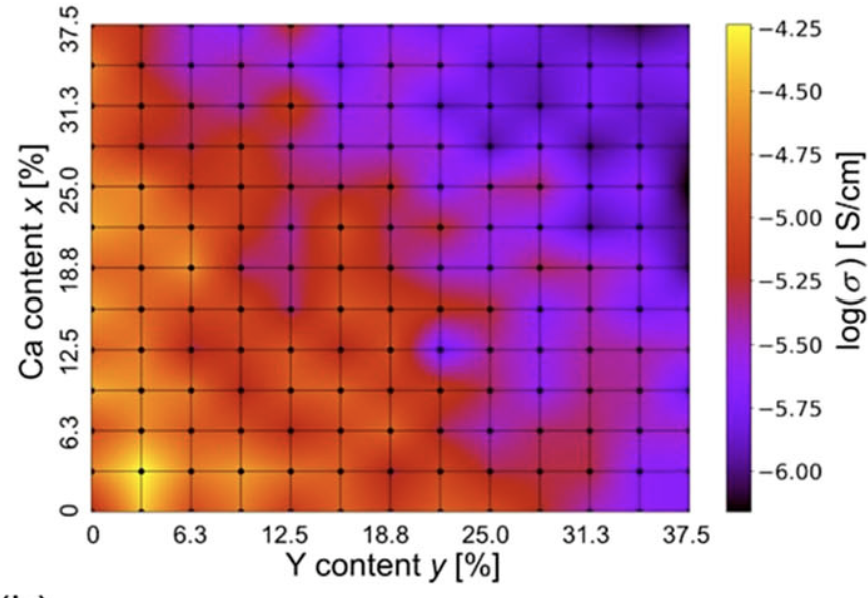

### タスク１，２共通
変数の定義（ユーザー作業必須）<BR>
sklearn等のインポート　（ユーザーは気にする必要なし）<BR>
ガウス過程、EI計算の関数定義　（ユーザーは気にする必要なし）<BR>

★注意：このプログラムにおける最適化は値を最大化する方向で進みます。値を下げる最適化をしたい場合は、あらかじめCSVファイルの目的変数に -1 をかけて符号をひっくり返してください。


In [ ]:
##################################################################################################
#                                 ユーザーが入力すべき箇所
##################################################################################################

#タスク１で使うファイル
path1=str("https://raw.githubusercontent.com/ChemicalBatteryLab-Nitech/dxgem_day1day2/main/data/LCYZP_36open.csv")
path1out=str("./LCYZP_36open_afterBO.csv")

#タスク２で使うファイル
path2=str("https://raw.githubusercontent.com/ChemicalBatteryLab-Nitech/dxgem_day1day2/main/data/LCYZP_allopen.csv")

#目的変数の列ラベル
target_column = 'log_sigma_300'
#記述子を定義するため削除すべき列のラベル
drop_columns = ['EA','log_sigma_300']

#GP, BOに関するパラメーター
optnum=0    # ハイパーパラメーターのチューニング回数（尤度を最大化する　０でも一回は最適化する）
alp=0.0001  # GPを安定化するためのパラメーター
tradeoff_e_val=0  # BO(EI戦略)のトレードオフパラメーター
loopnum=3  # タスク２で行う試行回数　（100階以上行うことを勧める)

##################################################################################################


import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn.gaussian_process as gp
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import random


%matplotlib inline

def gpr(train_nx,train_ny):
    kk=gp.kernels.RBF() * gp.kernels.ConstantKernel() #+ gp.kernels.WhiteKernel()
    #kk=gp.kernels.RBF(length_scale=2) 
    #kk=gp.kernels.Matern(nu=5)
    #kk=gp.kernels.Matern(nu=5) + gp.kernels.WhiteKernel()

    gpm = gp.GaussianProcessRegressor(kernel=kk,alpha=alp, n_restarts_optimizer=optnum, normalize_y=True)
    gpm.fit(train_nx, train_ny) 
    
    return gpm

def gpp(unknown_x,gpm):

    GPf, GPv = gpm.predict(unknown_x, return_cov=True)  # 予測値と分散共分散行列
    GPf = np.array(GPf).reshape(-1,1)
    GPsd = np.sqrt(np.diag(GPv)).reshape(-1,1)                   # 予測値の標準偏差
    return GPf, GPv, GPsd

    
def expected_improvement(func_value_xpoint,sigma_xpoint,func_value_best, tradeoff_e_val):
    
    fvx = func_value_xpoint
    sx = sigma_xpoint
    fvb = func_value_best
    te = tradeoff_e_val
    Z = (fvx-fvb-te)/sx
    ei = ((fvx-fvb-te)*norm.cdf(Z))+(sx*norm.pdf(Z))
    return ei 

def plot_2ddescriptors(x1, x2, y, size):

    plt.figure(figsize=(8, 6))

    sc = plt.scatter(
        x1, x2,
        c=y,                 # 色は目的変数で
        cmap="jet",          # jet カラーマップ
        s=size,               # マーカーサイズ    
        edgecolor='k'
    )

    plt.xlabel("Descriptor 1")
    plt.ylabel("Descriptor 2")
    plt.title("2D Descriptors Colored by Target")

    plt.colorbar(sc, label="Target Value")
    plt.tight_layout()
    plt.show()
    return


## タスク１


### タスク１ー１　データのロード

In [ ]:
df_original=pd.read_csv(path1, index_col=0)
df_original_descriptor=df_original.drop(drop_columns,axis=1)

df_fill = df_original.dropna()
df_vacant =df_original[df_original[target_column].isnull()]
df_vacant_descriptor=df_vacant.drop(drop_columns,axis=1)

df_descriptor = df_fill.drop(drop_columns, axis=1)
df_target = df_fill[target_column]

all_x=df_original_descriptor.values

train_x=df_descriptor.values
train_y=df_target.values.reshape(-1,1)

unknown_x=df_vacant_descriptor.values 

""" メモ

train_x (numpy)  既知材料の記述子行列
train_y (numpy)  既知材料の目的変数
all_x (numpy)  全データの記述子行列
unknown_x (numpy) 未知データの記述子行列
df_original (Pandas) 全データ行列

"""
display(df_original)
plot_2ddescriptors(train_x[:,0], train_x[:,1], train_y.flatten(), 100)


### タスク１ー２　訓練データ（既知データ）によるガウス過程回帰分析

In [ ]:

gpm=gpr(train_x,train_y)
print("Likelihood",gpm.log_marginal_likelihood())

GPf, GPv, GPsd=gpp(train_x, gpm)
current_ymax=np.max(train_y)

fig, ax = plt.subplots()
ax.errorbar(train_y.flatten(),GPf.flatten(),yerr=GPsd.flatten(),fmt='o')
ax.set_xlabel("true",fontsize=18)
ax.set_ylabel("prediction",fontsize=18)
plt.show()

x1 = train_x[:, 0]
x2 = train_x[:, 1]
pred = GPf.flatten()
std  = GPsd.flatten()
size = 50 + (std - std.min()) / (std.max() - std.min() + 1e-12) * 250

plot_2ddescriptors(x1, x2, pred, size)



### タスク１ー３　全データによる予測とEI値の出力（ファイル出力あり）

In [ ]:
GPf, GPv, GPsd=gpp(all_x, gpm)
current_ymax=np.max(train_y)
tradeoff_e_val=0
ei=expected_improvement(GPf,GPsd,current_ymax,tradeoff_e_val)
max_ei_id=np.argmax(ei)

df1=pd.DataFrame(GPf,columns=['GPf'],index=df_original.index)
df2=pd.DataFrame(GPsd,columns=['GPsd'],index=df_original.index)
df3=pd.DataFrame(ei,columns=['ei'],index=df_original.index)

df=pd.concat([df_original,df1,df2,df3],axis=1)
df.to_csv(path1out)

### ここから下は必須ではない(グラフを描画するだけ)　エラーが出るときはカット   ####

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_xlabel("sample ID",fontsize=20)
ax1.set_ylabel("prediction",fontsize=20)
ax2.set_ylabel("EI",fontsize=20)
ax1.errorbar(range(GPf.shape[0]),GPf.flatten(),yerr=GPsd.flatten(),fmt='o',color='gray')
ax2.scatter(range(GPf.shape[0]),ei,color='red',s=80,marker='x')
ax1.scatter(range(GPf.shape[0]),df[target_column],color='blue',s=80,marker='o')
fig.set_figheight(10)  # Figure sizeの指定 (高さ)
fig.set_figwidth(14)   # Figure sizeの指定 (幅)
plt.show()

x1 = all_x[:, 0]
x2 = all_x[:, 1]
pred = GPf.flatten()
std  = GPsd.flatten()

# 標準偏差をプロットサイズへ（見やすいようにスケーリング）
size = 50 + (std - std.min()) / (std.max() - std.min() + 1e-12) * 250
plot_2ddescriptors(x1, x2, pred, size)

x1 = all_x[:, 0]
x2 = all_x[:, 1]
pred = GPf.flatten()
std  = ei.flatten()

# 標準偏差をプロットサイズへ（見やすいようにスケーリング）
size = 50 + (std - std.min()) / (std.max() - std.min() + 1e-12) * 250
plot_2ddescriptors(x1, x2, pred, size)





## タスク２


### タスク２ー１　データのロード

In [ ]:
df_original=pd.read_csv(path2, index_col=0)
df_original_descriptor=df_original.drop(drop_columns,axis=1)
df_original_answer = df_original[target_column]

all_x=df_original_descriptor.values
all_y=df_original_answer.values.reshape(-1,1)


### タスク２ー２　ベイズ最適化の繰り返し検証

loopnumで設定した回数、手持ちのデーターでベイズ最適化の繰り返し検証を行う<BR>
後半はランダウサンプリングをloopnumで設定した回数実施<BR>


In [ ]:
save_ymax=np.array([])

for loop in range(loopnum):
    train_x=np.array([])
    train_y=np.array([])
    unknown_x=all_x
    unknown_y=all_y

    for i in range(len(all_x)-1):
    
        if i == 0:
            iadd=np.random.randint(len(all_y))
            train_x=unknown_x[iadd,:].reshape(1,-1)
            train_y=unknown_y[iadd,:].reshape(1,-1)
        else:
            iadd=max_ei_id
            train_x = np.vstack((train_x,unknown_x[iadd]))
            train_y = np.vstack((train_y,unknown_y[iadd]))
        
        unknown_x=np.delete(unknown_x,iadd,0)
        unknown_y=np.delete(unknown_y,iadd,0)
        
    
        gpm=gpr(train_x,train_y)
        GPf, GPv, GPsd=gpp(unknown_x, gpm)
        current_ymax=np.max(train_y)
        


        save_ymax=np.append(save_ymax,current_ymax)
        print ("loop",loop,"step",i, "best_y", current_ymax,"likelihood",gpm.log_marginal_likelihood())
        tradeoff_e_val=0
        ei=expected_improvement(GPf,GPsd,current_ymax,tradeoff_e_val)
       
        max_ei_id=np.argmax(ei)
        next_x=unknown_x[max_ei_id]
        
############ ここから　ランダムサンプリング ###############

random_x=np.linspace(0,len(all_x)-1,len(all_x))
save_rdmymax=[]

for loop in range(loopnum):
    random.shuffle(random_x)
    rdmy=[]
    current_rdmymax=-99999
    
    for i in range(len(all_x)-1):
        rdmy.append(float(all_y[int(random_x[i])]))
        current_rdmymax=np.max(rdmy)
        save_rdmymax=np.append(save_rdmymax,current_rdmymax)


### タスク２ー３　結果のグラフ表示


In [ ]:
#  最適化過程の描画

x=np.linspace(0,len(all_x)-1,len(all_x)-1)

s=save_ymax.reshape(loopnum,len(all_x)-1)
r=save_rdmymax.reshape(loopnum,len(all_x)-1) 

xmean=np.mean(s,axis=0)
xstd=np.std(s,axis=0)

xmeanr=np.mean(r,axis=0)
xstdr=np.std(r,axis=0)

f, ax = plt.subplots(1, 1, figsize=(10, 8))
  
lower = xmean-xstd
upper = xmean+xstd

lowerr = xmeanr-xstdr
upperr = xmeanr+xstdr

ax.plot(x,xmean)
ax.fill_between(x,lower, upper,alpha=0.3)


ax.plot(x,xmeanr,'red')
ax.fill_between(x,lowerr, upperr,alpha=0.3)

ax.set_xlim([0,170])
ax.set_ylim([-6, -4])
ax.set_xlabel('sampling number')
ax.set_ylabel('best values')

plt.show()